<a href="https://colab.research.google.com/github/bustardchad/ML_Turb/blob/main/Turb_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Framework for a simple U-net mapping between input and target variables
##  Model outline
#### Training phase

1. Gas density slices are downsampled and then upsampled

2. Loss is calculated as MSE loss against the corresponding target image, gradients are calculated, weights are updated, and we iterate.


#### Training data:
Currently set up to train on the subsonic MHD turbulent box simulations with initial plasma beta ~ 1 (Bustard and Oh 2023)

Data can be presplit or loaded in full



In [1]:
#@title Import packages and download data { display-mode: "form" }

# see what type of GPU we have
!nvidia-smi -L  

# import packages, download turbulence snapshots, etc.
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset, random_split
import pdb
import os

!pip install cmasher
!pip install torchmetrics
#!pip install git+https://github.com/huggingface/diffusers

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

GPU 0: Tesla T4 (UUID: GPU-42b2663c-f17f-d65e-7a70-81155b9ece29)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.1/367.1 KB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 KB 4.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 37.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    sim_type = 'unet'
    image_size = 128  # the generated image resolution
    batch_size = 64
    epochs = 20
    fileDirArr = ['MHD_beta10']
    field_list = ['density','magnetic_energy_density']
    data_presplit = True # whether data has already been split into training, val, test
    killPwr = False
    stop_early = False
    patience = 5
    run_locally = True
    run_colab = True
    path_to_dir = 'drive/MyDrive/Turb_Sims/Image_Cubes_noAugment/Full_Power/'
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = 'density_to_magnetic_firstTry'  # the model namy locally and on the HF Hub
    run_name = 'density_to_magnetic_firstTry'  # the model namy locally and on the HF Hub

config = TrainingConfig()

## Preprocess the data

In [4]:
# Download the relevant data from Google Drive
!pip install --upgrade --no-cache-dir gdown
import gdown

if (config.run_locally==False):

    # Path for the FULL google drive file with turb sim data
    # url = "https://drive.google.com/drive/folders/1C9zPwEglOZI7CqiS4Rz2MESCJzS4wTd2"

    # Path for the smaller turb sim data files (without augmentation)
    #url = "https://drive.google.com/drive/folders/1YDXgeazcwfyciAGUv_sW-gHDy7e1k5wY"

    url = "https://drive.google.com/drive/folders/1zzwYNPSV42jyEQVErlbE-CyKGIustlHv"

    if config.killPwr:
      url = "https://drive.google.com/drive/folders/1B7N_x5Y1N0wH96vKubyQ86Oftaz2M8W9"


    #if not os.path.exists("Image_Cubes_noAugment"):
    gdown.download_folder(url)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


fatal: destination path 'ML_Turb' already exists and is not an empty directory.
Training filenames:
/train_MHD_beta10_density.npy
/train_MHD_beta10_magnetic_energy_density.npy


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


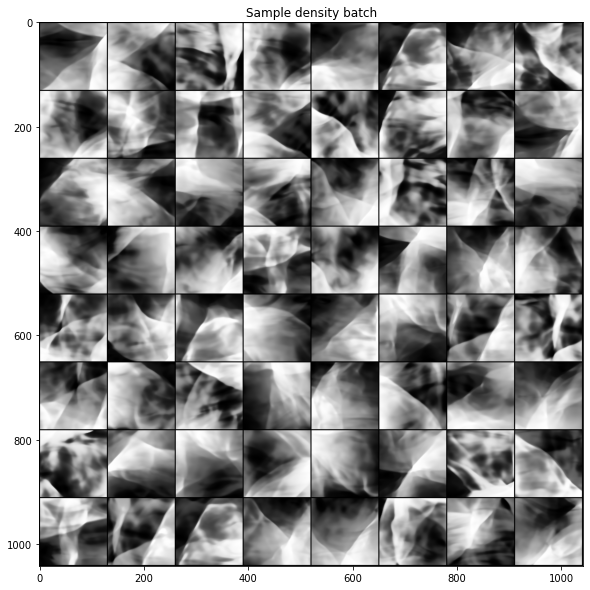

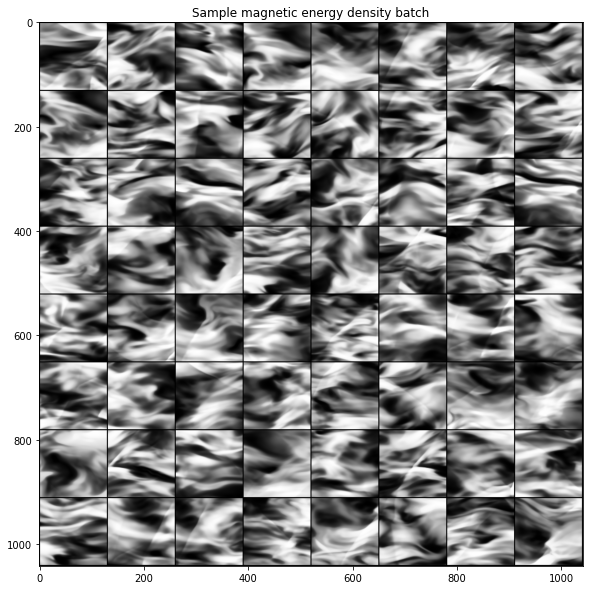

'\n# Using PIL\nfrom PIL import Image\nimport torchvision\n\ndef show_images(x):\n    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)\n    grid = torchvision.utils.make_grid(x)\n    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255\n    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))\n    return grid_im\n\nfor i, data in enumerate(train_dl):\n    x, y, z = data  \n    grid = show_images(x)\n    plt.imshow(grid)\n    break\n'

In [6]:
# If on Google Colab, need to clone repo to have access to helper files load_data and interpret_CNN

!git clone https://github.com/bustardchad/ML_Turb

import ML_Turb.utilities.load_data as load_data
#import load_data as load_data
import ML_Turb.utilities.interpret_CNN as interp

# load data
train_dl, valid_dl, test_dl = load_data.preprocess(config,augment=True)

from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def batch_imshow(img, title):
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(np.transpose( img.detach().cpu().numpy(), (1, 2, 0)), cmap='gray')
    plt.show()

for i, data in enumerate(train_dl):
    x, y, z = data  
    batch_imshow(make_grid(x, 8), title = 'Sample density batch')
    batch_imshow(make_grid(y, 8), title = 'Sample magnetic energy density batch')
    break  # we need just one batch

"""
# Using PIL
from PIL import Image
import torchvision

def show_images(x):
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im

for i, data in enumerate(train_dl):
    x, y, z = data  
    grid = show_images(x)
    plt.imshow(grid)
    break
"""

Set up loss function, metrics to track

In [32]:
# if val_loss decreases, write a checkpoint of model and return true
# if val_loss has increased for -patience- number of steps, return false
def _early_stopping(config, model, val_loss):
  if (len(val_loss) > 1):
    if (val_loss[-1] < val_loss[-2]):
      print("Saving model checkpoint")
      torch.save(model.state_dict(),config.run_name+'_checkpoint.pt')
      return True
  if (len(val_loss) > config.patience):
    if ((np.diff(val_loss[-config.patience:]) <= 0).all()):
      print("Early Stopping")
      return False
        

def loss_batch(loss_func, prediction, yb, opt=None):
    loss = loss_func(prediction, yb)
 
    #print(f"Metrics on batch: {batch_metrics}")

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(yb)

def fit(config, model, loss_func, opt, train_dl, valid_dl):
    # arrays to store losses
    loss_arr_train = []
    loss_arr_val = []
    keep_training = True
    for epoch in range(config.epochs):
        model.train()
        train_loss= 0
        num = 0
        for xb, yb, lbl in train_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            prediction = model(xb)

            loss, len = loss_batch(loss_func, prediction, yb, opt)

            train_loss += (loss*len)
            num += len

        train_loss = train_loss/num

        #print(f"current training stats={tracker_train.compute()}") 

        model.eval()
        with torch.no_grad():
          val_loss = 0
          num = 0
          for xb, yb, lbl in valid_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            prediction = model(xb)

            loss, len = loss_batch(loss_func, prediction, yb)

            val_loss += (loss*len)
            num += len

        val_loss = val_loss/num    

        #print(f"current validation stats={tracker_val.compute()}") 
        
        loss_arr_train.append(train_loss)
        loss_arr_val.append(val_loss)


        # Print out what's happening every epoch
        if epoch % 1 == 0:
          print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f}| Validation loss: {val_loss:.5f}")

        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        keep_training = _early_stopping(config, model, loss_arr_val)
        
        if ((keep_training==False) and (config.stop_early==True)):
          print("Early Stopping")
          # load the last checkpoint with the best model
          model.load_state_dict(torch.load(config.run_name+'_checkpoint.pt'))
          break

    return model, loss_arr_train, loss_arr_val
 

In [33]:
from ML_Turb.utilities.unet import UNet

# TODO: use Tensorboard to track performance

def create_model(config):
  # TODO: Change this part to use unet.py from elektronn3
  model = UNet(in_channels=1,
             out_channels=1,
             n_blocks=4,
             start_filts=8,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2).to(device)

  # learning rate and momentum (only for SGD)
  lr = 0.001
  mmtm = 0.9

  #loss_fn = nn.CrossEntropyLoss()
  loss_fn = nn.MSELoss()

  #opt = torch.optim.SGD(model.parameters(),
  #                            lr=lr,momentum=mmtm)
  opt = torch.optim.AdamW(model.parameters(), 
                                weight_decay = 0.01)

  return model, loss_fn, opt

  

## Run the U-net


In [34]:
# create the model
model, loss_fn, opt = create_model(config)

#from torchsummary import summary
#summary = summary(model, (1, 128, 128))

for data in iter(train_dl):
    x, y, z = data
    print(x.dtype, y.dtype, z.dtype)
    print(x.shape, y.shape, z.shape)
    with torch.no_grad():
        out = model(x.to(device))
        print(f'Out: {out.shape}')

    break # just do one

#!pip install torchsummary
#from torchsummary import summary

#summary = summary(model, (1, 128, 128))

# Make sure the input shape matches the output shape
#sample_image = x_with_channel[0].unsqueeze(0)
#output_shape = model(sample_image,timestep=0).sample.shape
#if (sample_image.shape == output_shape):
#    print("Input and output shapes match!")
#else:
#    print("Error: U-net output shape doesn't match image input shape")
#    print('Input shape:', sample_image.shape)
#    print('Output shape:', model(sample_image, timestep=0).sample.shape)

torch.float32 torch.float32 torch.int64
torch.Size([64, 1, 128, 128]) torch.Size([64, 1, 128, 128]) torch.Size([64])
Out: torch.Size([64, 1, 128, 128])


In [35]:
# run the model
model, loss_arr_train, loss_arr_val = fit(config, model, loss_fn, opt, train_dl, valid_dl)

Epoch: 0 | Train Loss: 0.15406| Validation loss: 0.08786
Epoch: 1 | Train Loss: 0.08298| Validation loss: 0.08584
Saving model checkpoint
Epoch: 2 | Train Loss: 0.07674| Validation loss: 0.08162
Saving model checkpoint
Epoch: 3 | Train Loss: 0.06826| Validation loss: 0.08177
Epoch: 4 | Train Loss: 0.06123| Validation loss: 0.07880
Saving model checkpoint
Epoch: 5 | Train Loss: 0.05448| Validation loss: 0.08682
Epoch: 6 | Train Loss: 0.04905| Validation loss: 0.09070
Epoch: 7 | Train Loss: 0.04488| Validation loss: 0.08621
Saving model checkpoint
Epoch: 8 | Train Loss: 0.03997| Validation loss: 0.09149
Epoch: 9 | Train Loss: 0.03680| Validation loss: 0.09838
Epoch: 10 | Train Loss: 0.03455| Validation loss: 0.08936
Saving model checkpoint
Epoch: 11 | Train Loss: 0.03279| Validation loss: 0.08952
Epoch: 12 | Train Loss: 0.03046| Validation loss: 0.09451
Epoch: 13 | Train Loss: 0.02954| Validation loss: 0.09003
Saving model checkpoint
Epoch: 14 | Train Loss: 0.02804| Validation loss: 0.09

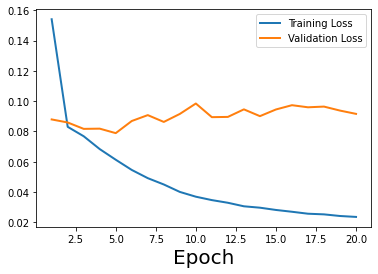

In [36]:
# assumes training and validation loss are each quantified at every epoch
num_epochs_run = np.arange(1,len(loss_arr_train)+1)

# plotting parameters
fs = 20

plt.plot(num_epochs_run, loss_arr_train, label = f"Training Loss", lw=2)
plt.plot(num_epochs_run, loss_arr_val, label = f"Validation Loss", lw=2)
plt.xlabel("Epoch", fontsize=fs)
plt.legend()
plt.show()

In [41]:
model = model.to('cpu')
model.eval()

# access a batch of labelled images
dataiter = iter(valid_dl)
x_arr, y_arr, labels = next(dataiter)

n_examples = 6
fig, axs = plt.subplots(3,n_examples,figsize=(int(8*n_examples/3),8))
with plt.style.context('fast'):
  for i in range(0,n_examples):
    x = x_arr[i]
    y = y_arr[i]
    # requires a 4D tensor, so need to reshape this 3D one
    image = x.reshape(1, 1, x.shape[1], x.shape[2])
    target = y.reshape(1, 1, y.shape[1], y.shape[2])
    
    target = target.reshape(target.shape[2],target.shape[3])
    target = target.detach().numpy()


    # we need to find the gradient with respect to the input image, so we need to call requires_grad_  on it
    image.requires_grad_()
    
    # run the model on the image
    outputs = model(image)

    input_image = image.reshape(image.shape[2],image.shape[3])
    input_image = input_image.detach().numpy()

    target_image = outputs.reshape(image.shape[2],image.shape[3])
    target_image = target_image.detach().numpy()
    
    axs[0,i].imshow(input_image,cmap='gray')
    axs[1,i].imshow(target,cmap='gray')
    axs[2,i].imshow(target_image,cmap='gray')

 
  cols = ['Example {}'.format(col) for col in range(1, n_examples+1)]
  rows = ['Input', 'Real Target', 'Modeled Target']

  for ax, col in zip(axs[0], cols):
      ax.set_title(col)

  for ax, row in zip(axs[:,0], rows):
      ax.set_ylabel(row, rotation=90, size='large')

  fig.tight_layout()
  plt.savefig("Unet_first_attempt.png",dpi=600)
  plt.close()

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
